In [1]:
"""
Title:       train.py
Description: Collection of functions to train the model.
Author:      Kunyu He, CAPP'20
"""

import numpy as np
import itertools

from matplotlib.font_manager import FontProperties
from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, precision_recall_curve)
from sklearn.metrics import precision_recall_curve, roc_curve

from viz import plot_predicted_scores, plot_precision_recall


INPUT_DIR = "../processed_data/"
OUTPUT_DIR = "../log/"

MODEL_NAMES = ["KNN", "Logistic Regression", "Decision Tree", "Linear SVM",
               "Random Forest"]
MODELS = [KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier,
          LinearSVC, RandomForestClassifier]

METRICS_NAMES = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC ROC Score"]
METRICS = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

THRESHOLDS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
SEED = 123

GRID_SEARCH_PARAMS = {"KNN": {
                              'n_neighbors': list(range(50, 110, 20)),
                              'weights': ["uniform", "distance"],
                              'metric': ["euclidean", "manhattan", "minkowski"]
                              },

                      "Logistic Regression": {
                                              'penalty': ['l1', 'l2'],
                                              'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                                              },

                      "Decision Tree": {
                            'criterion': ["entropy", "gini"],
                            'min_samples_split': list(np.arange(0.01, 0.06, 0.01)),
                            'max_depth': list(range(4, 11)),
                            'max_features': list(range(4, 15, 2))
                            },

                      "Linear SVM": {
                                     'penalty': ['l1', 'l2'],
                                     'C': [0.001, 0.01, 0.1, 1, 10]
                                     },

                      "Random Forest": {
                            'min_samples_split': list(np.arange(0.01, 0.06, 0.01)),
                            'max_depth': list(range(4, 11)),
                            'max_features': list(range(4, 15, 2))
                            }
                      }

DEFAULT_ARGS = {"KNN": {'n_jobs': -1},
                "Logistic Regression": {'random_state': SEED},
                "Decision Tree": {'random_state': SEED},
                "Linear SVM": {'random_state': SEED, 'max_iter': 100000},
                "Random Forest": {'n_estimators': 500, 'random_state': SEED,
                                  'oob_score': True}}


#----------------------------------------------------------------------------#
def ask():
    """
    """
    print("Up till now we support:\n")
    for i in range(len(MODEL_NAMES)):
        print("{}. {}".format(i, MODEL_NAMES[i]))
    model_index = int(input(("We use default Decision Tree as the benchmark.\n"
                             "Please input a classifier index (1, 2, or 3):\n")))

    print(("Up till now we use the following metrics to evaluate the"
           " fitted classifiers on the validation and test set.\n"))
    for i in range(len(METRICS)):
        print("{}. {}".format(i, METRICS[i].title()))
    metric_index = int(input("Please input a metrics index (1, 2, or 3):\n"))

    return model_index, metric_index


def load_features(dir_path=INPUT_DIR, test=True):
    """
    Load pre-processed feature matrices.

    """
    Xs = np.load(dir_path + 'X.npz')
    ys = np.load(dir_path + 'y.npz')

    if not test:
        X_train = Xs['train']
        y_train = ys['train']
        return X_train, y_train

    X_train, X_test = Xs['train'], Xs['test']
    y_train, y_test = ys['train'], ys['test']
    return X_train, X_test, y_train, y_test


def build_benchmark(data, metric_index):
    """
    """
    X_train, X_test, y_train, y_test = data

    benchmark = DecisionTreeClassifier(**DEFAULT_ARGS["Decision Tree"])
    benchmark.fit(X_train, y_train)
    predicted_probs = benchmark.predict_proba(X_test)[:, 1]
    score = METRICS[metric_index - 1](y_test, benchmark.predict(X_test))

    print("{} of the benchmark default decision tree model is {:.4f}.".\
          format(METRICS_NAMES[metric_index - 1], round(score, 4)))


def clf_predict_proba(clf, X_test):
    """
    """
    if hasattr(clf, "predict_proba"):
        predicted_prob = clf.predict_proba(X_test)[:, 1]
    else:
        prob = clf.decision_function(X_test)
        predicted_prob = (prob - prob.min()) / (prob.max() - prob.min())

    return predicted_prob


def cross_validation(clf, skf, data, metric_index, threshold):
    """
    """
    X_train, y_train = data
    predicted_probs, scores = [], []

    for train, validation in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train], X_train[validation]
        y_tr, y_val = y_train[train], y_train[validation]

        try:
            clf.fit(X_tr, y_tr)
        except:
            return None, 0.0
        predicted_prob = clf_predict_proba(clf, X_val)
        predicted_labels = np.where(predicted_prob > threshold, 1, 0)

        predicted_probs.append(predicted_prob)
        scores.append(METRICS[metric_index - 1](y_val, predicted_labels))

    return list(itertools.chain(*predicted_probs)), np.array(scores).mean()


def find_best_threshold(model_index, metric_index, train_data,
                        verbose=False, plot=False):
    """
    """
    model_name = MODEL_NAMES[model_index - 1]
    metric_name = METRICS_NAMES[metric_index - 1]
    default_args = DEFAULT_ARGS[model_name]

    clf = MODELS[model_index - 1](**default_args)
    skf = StratifiedKFold(n_splits=5, random_state=SEED)

    if plot:
        default_probs, _ = cross_validation(clf, skf, train_data, metric_index, 0.5)
        plot_predicted_scores(default_probs)

    best_score, best_threshold = 0, None
    print("Default {}. Search Starts:".format(model_name))
    for threshold in THRESHOLDS:
        _, score = cross_validation(clf, skf, train_data, metric_index, threshold)
        if verbose:
            print("\t(Threshold: {}) the cross-validation {} is {:.4f}".\
                  format(threshold, metric_name, score))
        if score > best_score:
            best_score, best_threshold = score, threshold

    print("Search Finished: The best threshold to use is {:.4f}.".format(best_threshold))
    return best_threshold


def tune(model_index, metric_index, train_data, best_threshold,
         n_folds=10, verbose=False):
    """
    Use grid search and cross validation to find the best set of hyper-
    parameters.

    """
    model_name = MODEL_NAMES[model_index - 1]
    metric_name = METRICS_NAMES[metric_index - 1]
    params_grid = GRID_SEARCH_PARAMS[model_name]
    default_args = DEFAULT_ARGS[model_name]

    best_score, best_grid = 0, None
    params = params_grid.keys()
    skf = StratifiedKFold(n_splits=n_folds, random_state=SEED)

    print("{} with Decision Threshold {}. Search Starts:".format(model_name,
                                                                 best_threshold))
    for grid in itertools.product(*(params_grid[param] for param in params)):
        args = dict(zip(params, grid))
        clf = MODELS[model_index - 1](**default_args, **args)
        _, grid_score = cross_validation(clf, skf, train_data, metric_index, best_threshold)

        if grid_score > best_score:
            best_score, best_grid = grid_score, args
        if verbose:
            print("\t(Parameters: {}), cross-validation {} of {:.4f}".format(args, metric_name,
                                                                             grid_score))

    print("Search Finished: The best parameters to use is {}".format(best_grid))
    return best_grid, best_score


def evaluate_best_model(model_index, metric_index, best_threshold, best_grid, data,
                        plot=False, verbose=True):
    """
    """
    X_train, X_test, y_train, y_test = data
    model_name = MODEL_NAMES[model_index - 1]
    metric_name = METRICS_NAMES[metric_index - 1]
    default_args = DEFAULT_ARGS[model_name]

    clf = MODELS[model_index - 1](**default_args, **best_grid)
    clf.fit(X_train, y_train)

    predicted_prob = clf_predict_proba(clf, X_test)
    predicted_labels = np.where(predicted_prob > best_threshold, 1, 0)
    print(("Our {} classifier reached a(n) {} of {:.4f} with a decision"
           " threshold of {} on the test set.").format(model_name, metric_name,
               METRICS[metric_index - 1](y_test, predicted_labels), best_threshold))

    if plot:
        pos = np.count_nonzero(np.append(y_train, y_test))
        prop = pos / (len(y_test) + len(y_train))
        plot_precision_recall(predicted_prob, y_test, prop)


In [2]:
X_train, X_test, y_train, y_test = load_features()

In [3]:
benchmark = DecisionTreeClassifier(**DEFAULT_ARGS["Decision Tree"])
benchmark.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

Default Linear SVM. Search Starts:
	(Threshold: 0.01) the cross-validation Accuracy is 0.1613
	(Threshold: 0.02) the cross-validation Accuracy is 0.1619
	(Threshold: 0.05) the cross-validation Accuracy is 0.1697
	(Threshold: 0.1) the cross-validation Accuracy is 0.1946
	(Threshold: 0.2) the cross-validation Accuracy is 0.2120
	(Threshold: 0.3) the cross-validation Accuracy is 0.2164
	(Threshold: 0.4) the cross-validation Accuracy is 0.2178
	(Threshold: 0.5) the cross-validation Accuracy is 0.2873
	(Threshold: 0.6) the cross-validation Accuracy is 0.7964
	(Threshold: 0.7) the cross-validation Accuracy is 0.8612
	(Threshold: 0.8) the cross-validation Accuracy is 0.8730
Search Finished: The best threshold to use is 0.8000.


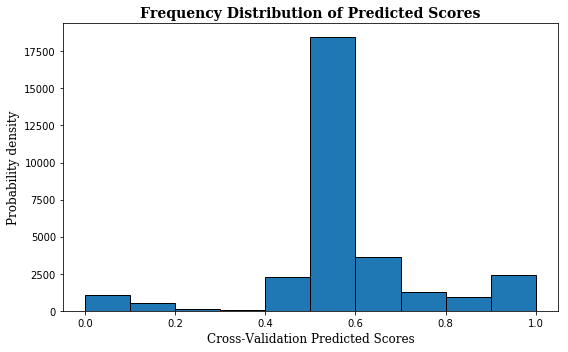

In [4]:
best_threshold = find_best_threshold(4, 1, [X_train, y_train], verbose=True, plot=True)

In [5]:
best_grid, best_score = tune(4, 1, [X_train, y_train], best_threshold, n_folds=5, verbose=True)

Linear SVM with Decision Threshold 0.8. Search Starts:
	(Parameters: {'penalty': 'l1', 'C': 0.001}), cross-validation Accuracy of 0.0000
	(Parameters: {'penalty': 'l1', 'C': 0.01}), cross-validation Accuracy of 0.0000
	(Parameters: {'penalty': 'l1', 'C': 0.1}), cross-validation Accuracy of 0.0000
	(Parameters: {'penalty': 'l1', 'C': 1}), cross-validation Accuracy of 0.0000
	(Parameters: {'penalty': 'l1', 'C': 10}), cross-validation Accuracy of 0.0000
	(Parameters: {'penalty': 'l2', 'C': 0.001}), cross-validation Accuracy of 0.8717
	(Parameters: {'penalty': 'l2', 'C': 0.01}), cross-validation Accuracy of 0.8726
	(Parameters: {'penalty': 'l2', 'C': 0.1}), cross-validation Accuracy of 0.8731
	(Parameters: {'penalty': 'l2', 'C': 1}), cross-validation Accuracy of 0.8730
	(Parameters: {'penalty': 'l2', 'C': 10}), cross-validation Accuracy of 0.8724
Search Finished: The best parameters to use is {'penalty': 'l2', 'C': 0.1}


Our Linear SVM classifier reached a(n) Accuracy of 0.8669 with a decision threshold of 0.8 on the test set.


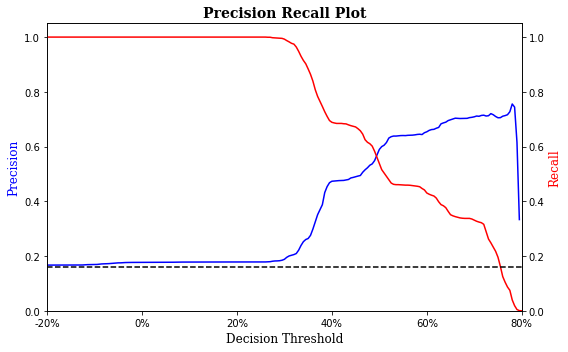

In [6]:
evaluate_best_model(4, 1, best_threshold, best_grid, [X_train, X_test, y_train, y_test], plot=True)